In [1]:
"""
Using PCA to extract order pramameters of ferromagnetic Ising model
"""

'\nUsing PCA to extract order pramameters of ferromagnetic Ising model\n'

In [51]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rcParams
import pandas as pd

In [84]:
plt.style.use('classic')
plt.style.use('seaborn-bright')
rcParams.update({"legend.handletextpad": 0.3,
                 "legend.labelspacing": 0.3,
                 "legend.fontsize": 12,
                 "legend.markerscale":1.2,
                 "legend.frameon": True,
                 "legend.numpoints": 1,
                 "xtick.top": 1,
                 "xtick.bottom": 1,
                 "ytick.left": 1,
                 "ytick.right": 1,
                 "savefig.dpi": 300.0,
                })
"""
                 "axes.labelsize":15,
                 "xtick.labelsize":14,
                 "ytick.labelsize":14,
                 "xtick.major.pad":8,
                 "xtick.direction": 'in',
                 "ytick.direction": 'in',
                 "xtick.minor.visible": True,
                 "ytick.minor.visible": True,
                 })
"""

'\n                 "axes.labelsize":15,\n                 "xtick.labelsize":14,\n                 "ytick.labelsize":14,\n                 "xtick.major.pad":8,\n                 "xtick.direction": \'in\',\n                 "ytick.direction": \'in\',\n                 "xtick.minor.visible": True,\n                 "ytick.minor.visible": True,\n                 })\n'

In [15]:
def initialize(nlist,L,N):       
    """get neighbors of each sites
    """             
    for i in range(N):
        nlist[i][0] = (i-1)%N
        nlist[i][1] = (i-L)%N
        nlist[i][2] = (i+1)%N
        nlist[i][3] = (i+L)%N   
    return nlist

def measure(J,spin,nlist,N,Nobs):
    
    observable=np.zeros(Nobs, dtype=np.float64)
    
    observable[0] = np.abs(np.sum(spin))  # magnetization 
    for i in range(N):
        tmp = J * spin[i] * (spin[nlist[i][0]] + spin[nlist[i][1]]) 
        observable[1] = observable[1] + tmp
    observable[1] = observable[1]  # energy
    observable[2] = observable[0]**2  # m^2
    observable[3] = observable[1]**2    # e^2

    return observable

def recalc_obser(L, tem, confs, bin_num, Nobs=4):
    N = L**2; J = -1
    nlist = np.zeros([N,4], dtype=np.int64)
    nlist = initialize(nlist,L,N)
    obser = np.zeros((Nobs, bin_num), dtype=np.float64)
    confbins = np.split(np.arange(0,confs.shape[0]), bin_num) # average the observables in each bins
    iT=1.0/tem; iT2=iT*iT
    for ib, bins in enumerate(confbins):
        lenbin = len(bins)
        n1, n2  = 1.0/(lenbin), 1.0/(lenbin*lenbin)
        M1, E1, M2, E2 = 0,0,0,0
        for mcstep in bins:
            tmpconf = confs[mcstep] # M*N 
            tmp = measure(J,tmpconf,nlist,N,Nobs)
            M1 += tmp[0]; E1 += tmp[1]
            M2 += tmp[2]; E2 += tmp[3]
        obser[0,ib] = n1*E1 / N
        obser[1,ib] = n1*M1 / N
        obser[2,ib] = (n1*E2 - n2*E1*E1)*iT2 / N
        obser[3,ib] = (n1*M2 - n2*M1*M1)*iT / N    ## analysis
    mobs = np.mean(obser, axis=1)
    errobs = np.std(obser, axis=1)*np.sqrt(bin_num/(bin_num-1.0))
    return mobs, errobs


In [43]:
def init_datapath(L):
    """init the data file path in an directory Ll
    """
    dirpath = os.path.join(os.getcwd(), 'Wolff/L%i'%L)
    data_p = {}
    data_o = {}
    for file in os.listdir(dirpath):
        if "spinconf" in file:
            tem = file[file.index('T')+1:file.index('T')+7]
            data_p[tem] = os.path.join(dirpath, file) # store file path
        if "observation" in file:
            tem = file[file.index('T')+1:file.index('T')+7]
            data_o[tem] = os.path.join(dirpath, file) # store file path
    return data_p, data_o

def read_isingConfig(data_p, data_o, L, Ts, Tsarg, bin_num):
    """data_p is the data file path
    Tsarg is the index sorted by temperature"""
    data_pv = list(data_p.values())
    data_ov = list(data_o.values())
    isingC = []
    for idx, T in enumerate(Ts):
        datapath = data_pv[ Tsarg[idx] ]
        obsrpath = data_ov[ Tsarg[idx] ]
        ## load data from pandas
        df = pd.read_csv(datapath)
        configmat = [] # M*N matrix. N: sites; M: measure steps
        for mcstep in df.keys():
            configmat.append( df[mcstep] )
        df_obsr = pd.read_csv(obsrpath)
        wm = int(df_obsr.columns[2]) # get mearsure step
        configmat = np.array(configmat)[wm:]
        binsteps = np.linspace(0, configmat.shape[0], bin_num, dtype=int, endpoint=0) # default bin num: 2**7
        isingC.append( configmat[binsteps] )# binning
    return isingC

In [65]:
def load_X(L, bin_num=2**7):
    data_p, data_o = init_datapath(L)
    Ts = np.array( [t for t in data_p.keys()], dtype=np.float64 )
    Tsarg = np.argsort(Ts, axis=0, kind='quicksort')
    Ts = Ts[Tsarg]
    print(Ts)
    isingC = read_isingConfig(data_p, data_o, L, Ts, Tsarg, bin_num)
    ## Ts [t1,t2,...,tm]
    ## each isingC[Ts] has the shape 2**7 x N
    #for t in Ts[Tsarg]:
    #    print(isingC[t].shape)
    X = np.array(isingC, dtype = np.int8)
    print(X.shape)
    X = np.vstack(X)
    print(X.shape)
    return X, Ts

In [ ]:
## load data
X10, _ = load_X(L=10)
X20, _ = load_X(L=20)
X40, _ = load_X(L=40)

(386, 1600)


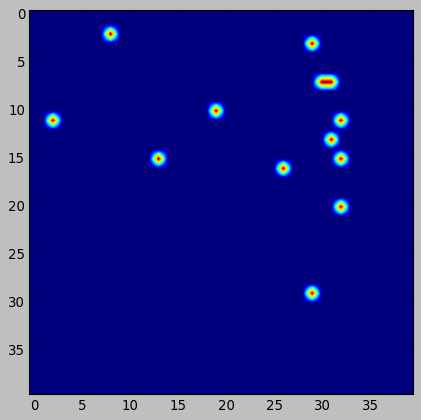

(386, 1600)


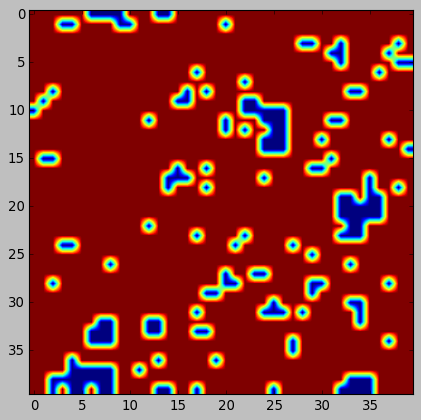

(386, 1600)


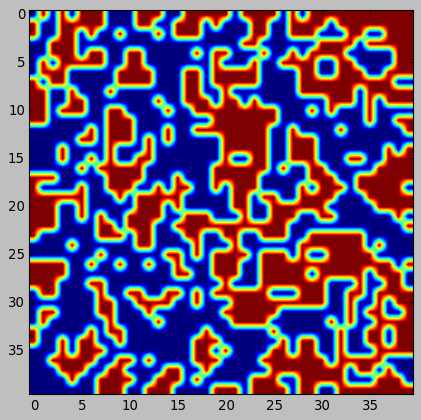

In [169]:
"""show some Ising samples"""
## load data from pandas
def read_single_Ising(datapath):
    df = pd.read_csv(datapath)
    configmat = [] # M*N matrix. N: sites; M: measure steps
    for mcstep in df.keys():
        configmat.append( df[mcstep] )
    return configmat

data_p, data_o = init_datapath(L=40)
## T
plt.clf()
this_t = ['1.5000','2.2800','3.3000']
for t in this_t:
    config = np.array(read_single_Ising(data_p['%s'%t]))
    print(config.shape)
    configmat = np.reshape(config[-2], (40,40))
    plt.imshow(configmat)
    plt.show()

In [45]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score

In [46]:
"""start traing pca
"""
def compute_scores(X, n_components):
    pca = PCA(svd_solver='full')
    #cv_splitter = KFold(n_splits=5, shuffle=False)
    pca_scores = []
    pca_errors = []
    for n in n_components:
        pca.set_params(n_components = n)
        scores = cross_val_score(pca, X, cv=5)#cv=cv_splitter)
        pca_scores.append(np.mean(scores))
        pca_errors.append(np.std(scores))
    print('complete score')
    return pca_scores, pca_errors

n_components = np.arange(1,9,1,dtype=int)
pca_scores = np.zeros((3, n_components.size))
pca_errors = np.zeros((3, n_components.size))
pca_scores[0], pca_errors[0] = compute_scores(X10, n_components)
pca_scores[1], pca_errors[1] = compute_scores(X20, n_components)
pca_scores[2], pca_errors[2] = compute_scores(X40, n_components)

complete score
complete score
complete score


<Figure size 640x480 with 0 Axes>

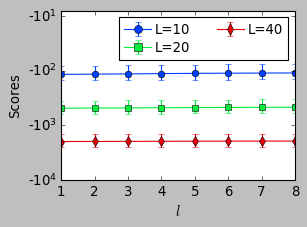

In [60]:
plt.clf()
fig1, ax1 = plt.subplots(figsize=(4,3), tight_layout=True)
for i in range(3):
    ax1.errorbar(n_components, pca_scores[i], pca_errors[i], marker=['o','s','d'][i], label='L=%i'%[10,20,40][i])

plt.xlabel(r'$l$',fontsize=13); plt.ylabel('Scores')
plt.ylim(-1e4,-8)
plt.legend(ncol=2,fontsize=12)
plt.yscale('symlog')
plt.savefig('Fig/PCA scores.png')

In [57]:
def compute_lambd(pca, X):
    cv_splitter = KFold(n_splits=4)
    singular_values = []
    for train, _ in cv_splitter.split(X):
        print(train.shape)
        pca.fit(X[train])
        singular_values.append(pca.singular_values_)
    return singular_values

y, yerr = np.zeros((3,8),dtype=np.float64), np.zeros((3,8),dtype=np.float64)
pca_8 = PCA(svd_solver='full', n_components=8)
print('L=',10)
singular_values = compute_lambd(pca_8, X10)
y[0] = np.mean(singular_values, axis=0)
yerr[0] = np.std(singular_values, axis=0)
print('L=',20)
pca_8 = PCA(svd_solver='full', n_components=8)
singular_values = compute_lambd(pca_8, X20)
y[1] = np.mean(singular_values, axis=0)
yerr[1] = np.std(singular_values, axis=0)
print('L=',40)
pca_8 = PCA(svd_solver='full', n_components=8)
singular_values = compute_lambd(pca_8, X40)
y[2] = np.mean(singular_values, axis=0)
yerr[2] = np.std(singular_values, axis=0)

L= 10
(2976,)
(2976,)
(2976,)
(2976,)
L= 20
(2976,)
(2976,)
(2976,)
(2976,)
L= 40
(2976,)
(2976,)
(2976,)
(2976,)


<Figure size 640x480 with 0 Axes>

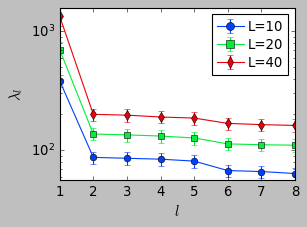

In [61]:
plt.clf()
fig2, ax2 = plt.subplots(figsize=(4,3), tight_layout=True)
for i in range(3):
    ax2.errorbar(n_components, y[i], yerr[i], marker=['o','s','d'][i], label='L=%i'%[10,20,40][i])

plt.xlabel(r'$l$',fontsize=13); plt.ylabel(r'$\lambda_l$',fontsize=13)
plt.legend(ncol=1,fontsize=12)
plt.yscale('log');   plt.axis('tight')
#plt.ylim(7e1,2e3)
plt.savefig('Fig/PCA Ncomponents.png')

In [66]:
"""More pca feature and temperature
"""
Xnow, tsnow = load_X(L=40, bin_num=2**7)
## initialize 2 component PCA
pca_2 = PCA(svd_solver='full', n_components=2)
## fit with L40 data
pca_2.fit(Xnow)

[1.5  1.56 1.62 1.68 1.74 1.8  1.86 1.92 1.98 2.04 2.1  2.16 2.22 2.28
 2.34 2.4  2.46 2.52 2.58 2.64 2.7  2.76 2.82 2.88 2.94 3.   3.06 3.12
 3.18 3.24 3.3 ]
(31, 128, 1600)
(3968, 1600)


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [76]:
"""
Above fitting processes are unsupervised. Now we add the label: temperature
2-dim PCA
"""
## initialize 2 component PCA
pca_2 = PCA(svd_solver='full', n_components=2)
## fit with L10 data
X10, ts10 = load_X(L=10, bin_num=2**6) # fetch less data
pca_2.fit(X10)
X10_2d = pca_2.transform(X10)
## fit with L20 data
X20, ts20 = load_X(L=20, bin_num=2**6)
pca_2.fit(X20)
X20_2d = pca_2.transform(X20)
## fit with L40 data
X40, ts40 = load_X(L=40, bin_num=2**6)
pca_2.fit(X40)
X40_2d = pca_2.transform(X40)
## expanding the temperature to meet X40 (color)
newts10 = np.repeat(ts10,repeats=X10.shape[0]//ts10.size)
newts20 = np.repeat(ts20,repeats=X20.shape[0]//ts20.size)
newts40 = np.repeat(ts40,repeats=X40.shape[0]//ts40.size)

[1.5  1.56 1.62 1.68 1.74 1.8  1.86 1.92 1.98 2.04 2.1  2.16 2.22 2.28
 2.34 2.4  2.46 2.52 2.58 2.64 2.7  2.76 2.82 2.88 2.94 3.   3.06 3.12
 3.18 3.24 3.3 ]
(31, 64, 100)
(1984, 100)
[1.5  1.56 1.62 1.68 1.74 1.8  1.86 1.92 1.98 2.04 2.1  2.16 2.22 2.28
 2.34 2.4  2.46 2.52 2.58 2.64 2.7  2.76 2.82 2.88 2.94 3.   3.06 3.12
 3.18 3.24 3.3 ]
(31, 64, 400)
(1984, 400)
[1.5  1.56 1.62 1.68 1.74 1.8  1.86 1.92 1.98 2.04 2.1  2.16 2.22 2.28
 2.34 2.4  2.46 2.52 2.58 2.64 2.7  2.76 2.82 2.88 2.94 3.   3.06 3.12
 3.18 3.24 3.3 ]
(31, 64, 1600)
(1984, 1600)


Text(0.5, 0, '$z_1$')

<Figure size 640x480 with 0 Axes>

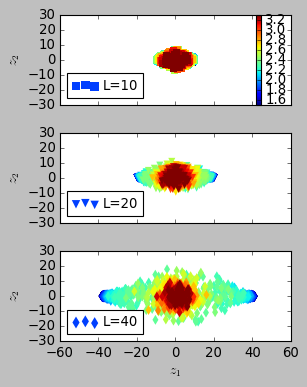

In [130]:
## plot 2d feature
plt.clf()
fig4, axes = plt.subplots(3,1,figsize=(4,5),sharex=True, tight_layout=True)
y10_2d = X10_2d.T ## [d1, d2]
axes[0].scatter(y10_2d[0], y10_2d[1], marker='s', edgecolor='none', 
                c=newts10, s=40, label='L=10', cmap=plt.cm.jet)
y20_2d = X20_2d.T ## [d1, d2]
cl = axes[1].scatter(y20_2d[0], y20_2d[1], marker='v', edgecolor='none', 
                c=newts20, s=40, label='L=20', cmap=plt.cm.jet)
y40_2d = X40_2d.T ## [d1, d2]
cl = axes[2].scatter(y40_2d[0], y40_2d[1], marker='d', edgecolor='none', 
                     c=newts40, s=40, label='L=40', cmap=plt.cm.jet)
fig4.colorbar(cl, ax=axes[0], pad=-.15)
for i in range(3):
    axes[i].yaxis.set_major_locator(plt.MultipleLocator(10))
    axes[i].set_ylim(-30,30)
    axes[i].set_ylabel(r'$z_2$')
    if i==0: 
        axes[i].legend(loc='lower left')
    else:
        axes[i].legend(loc='lower left')
plt.xlabel(r'$z_1$')

In [90]:
from sklearn import metrics
from sklearn.cluster import KMeans, MeanShift

In [91]:
kmeans20 = KMeans(init='k-means++', n_clusters=3, n_init=1)
kmeans20.fit(X20_2d)
kmeans40 = KMeans(init='k-means++', n_clusters=3, n_init=1)
kmeans40.fit(X40_2d)
ms20 = MeanShift(bin_seeding=True, cluster_all=True)
ms20.fit(X40_2d)
ms40 = MeanShift(bin_seeding=True, cluster_all=True)
ms40.fit(X40_2d)

MeanShift(bandwidth=None, bin_seeding=True, cluster_all=True, min_bin_freq=1,
          n_jobs=None, seeds=None)

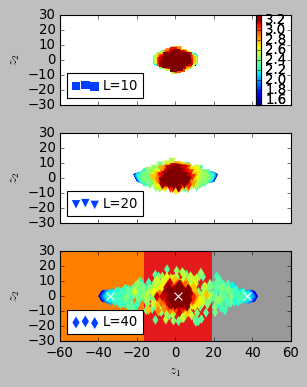

In [131]:
dh = .05     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = axes[i].get_xlim()
y_min, y_max = axes[i].get_ylim()
xx, yy = np.meshgrid(np.arange(x_min, x_max, dh), np.arange(y_min, y_max, dh))

# Obtain labels for each point in mesh. Use last trained model.
#Z20 = kmeans20.predict(np.c_[xx.ravel(), yy.ravel()])
#Z40 = kmeans40.predict(np.c_[xx.ravel(), yy.ravel()])
#Zs20 = ms20.predict(np.c_[xx.ravel(), yy.ravel()])
Zs40 = ms40.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot in the previous sub-figure
#Zs20 = Zs20.reshape(xx.shape)
#Z40 = Z40.reshape(xx.shape)
Zs40 = Zs40.reshape(xx.shape)

#
#Zs40tmp = np.where(Zs40==2,0,0)+np.where(Zs40==0,1,0)+np.where(Zs40==1,2,0)

#axes[1].imshow(Zs20, interpolation='nearest',
#           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#           cmap=plt.cm.Set1,
#           aspect='auto', origin='lower')
axes[2].imshow(Zs40, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Set1,
           aspect='auto', origin='lower')

centroids = ms40.cluster_centers_
axes[2].scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=50, linewidths=8,
            color='w', zorder=10)
#centroids = kmeans40.cluster_centers_
#cluster_centers = ms40.cluster_centers_
#axes[2].scatter(cluster_centers[:, 0], cluster_centers[:, 1],
#            marker='x', s=50, linewidths=5,
#            color='w', zorder=10)
fig4.colorbar(cl, ax=axes[0], pad=-.15)
fig4.savefig('pca2d.png')
fig4

2

In [67]:
"""
One PCA as a funtion of temperature
"""
## transform L40 data to pca_1 1d-feature
Xnow_1d = pca_1.transform(Xnow)
#X20d = pca_1.transform(np.hstack([X20,X20,X20,X20])) # test false data
## grouping 1d-feature by temperature
Xnow_1dt = np.array_split(Xnow_1d.ravel(), tsnow.size)
#X20dt = np.array_split(X20d.ravel(), ts20.size) # test false data

In [96]:
## averaging X1dt
ydt = np.mean(np.abs(Xnow_1dt), axis=1)
yerrdt = np.std(np.abs(Xnow_1dt), axis=1)

mscale = 1.0/40.0 #np.abs(ob40[0,1]) / ydt[0]

tc = 2/np.log(1+np.sqrt(2))
print(tc)

2.269185314213022


In [110]:
## predict by MeanShift the boundary in 1D
zsnow = np.mean(Zs40, axis=0)
xxnow = xx[0]

-16.450000000002476 19.1499999999955


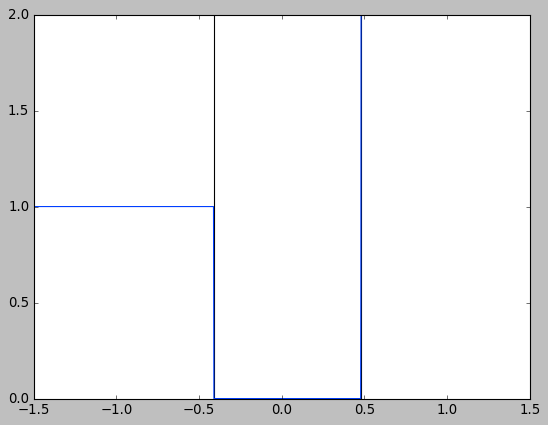

In [128]:
plt.plot(xxnow * mscale, zsnow)
x0 = xxnow[ np.where(zsnow==0)[0][0]-1 ]
x1 = xxnow[ np.where(zsnow==0)[0][-1]+1 ]
plt.vlines(x0*mscale,0.,2.0)
plt.vlines(x1*mscale,0.,2.0)
print(x0, x1)

<Figure size 640x480 with 0 Axes>

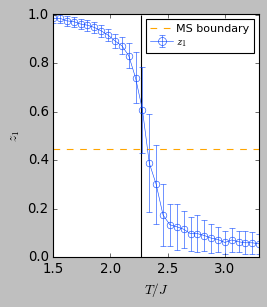

In [154]:
## plot
plt.clf()
fig3, ax3 = plt.subplots(figsize=(3.5,4),tight_layout=True)

ax3.errorbar(tsnow, ydt * mscale, yerrdt * mscale, fmt='-o', lw=0.5, fillstyle='none', label=r'$z_1$')
ax3.vlines(tc,0,1,linestyles='-')
## possible bound
#ax3.plot([tsnow[0],tsnow[-1]],[abs(x0)*mscale,abs(x0)*mscale],ls='--',color='r')
#ax3.plot([tsnow[0],tsnow[-1]],[abs(x1)*mscale,abs(x1)*mscale], ls='--',color='r',label=r'MS boundary')
ax3.plot([tsnow[0],tsnow[-1]],[(abs(x0)+abs(x1))*mscale/2,(abs(x0)+abs(x1))*mscale/2], ls='--',color='orange',label=r'MS boundary')

plt.axis('tight')
plt.ylabel(r'$z_1$')
plt.xlabel(r'$T/J$')
plt.legend(fontsize=10)
fig3.savefig('Fig/PCA featureT.png')

In [199]:
"""reverse generating Ising sample, using z1 principle component
"""
## initialize 1 component PCA
pca_2 = PCA(svd_solver='full', n_components=2)
## fit with L40 data
pca_2.fit(Xnow)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [200]:
pca_2.transform(Xnow)

array([[-38.88256559,   0.14509268],
       [ 40.41402713,  -0.13150251],
       [-39.03260271,   0.10395526],
       ...,
       [  0.11860759,   0.65662059],
       [  5.39044772,  -0.39299245],
       [ -1.18096151,  -1.31465757]])

In [236]:
know_fea = np.array([[1/mscale,(abs(x0)+abs(x1))/2,0]]).T
know_fea = np.c_[know_fea, np.zeros_like(know_fea)]
tindex = [r'$J/T\to 0$', r'$T_c$',r'$T/J\to0$']
print(know_fea)
prdc_Xnow = pca_2.inverse_transform(know_fea)
print(prdc_Xnow.shape)

[[40.   0. ]
 [17.8  0. ]
 [ 0.   0. ]]
(3, 1600)


In [237]:
import seaborn as sns

<Figure size 640x480 with 0 Axes>

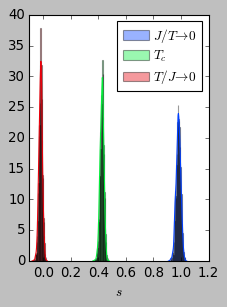

In [245]:
plt.clf()
fig, ax = plt.subplots(figsize=(3,4),tight_layout=True)
for i in range(3):
    sns.distplot(prdc_Xnow[i], label=tindex[i], ax=ax)
plt.xlim(-0.1,)
ax.legend(); plt.xlabel(r'$s$')
fig.savefig('Fig/PCAinvdistplot.png')

In [242]:
"""load real Ising"""
data_p, data_o = init_datapath(L=40)
this_t = ['1.5000','2.2800','3.3000']
config_0 = np.array(read_single_Ising(data_p['%s'%this_t[0]]))
config_1 = np.array(read_single_Ising(data_p['%s'%this_t[1]]))
config_2 = np.array(read_single_Ising(data_p['%s'%this_t[2]]))
orig_isingc = [ config_0[-1],config_1[-1],config_2[-1] ]
orig_isingc = [ np.reshape(mat, (40,40)) for mat in orig_isingc ]

<Figure size 640x480 with 0 Axes>

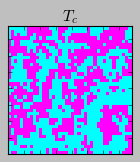

In [243]:
def config_plot(ax,config,l,tem):
    X, Y = np.meshgrid(range(l), range(l))
    ax.xaxis.set_ticklabels('')
    ax.yaxis.set_ticklabels('')
    ax.pcolormesh(X, Y, config, cmap=plt.cm.cool, vmin=-1, vmax=1);
    ax.set_title(str(tem))
    ax.axis('tight')

plt.clf()
fig, ax = plt.subplots(figsize=(2,2))
config_plot(ax, orig_isingc[2],40,r'$T_c$')

<Figure size 640x480 with 0 Axes>

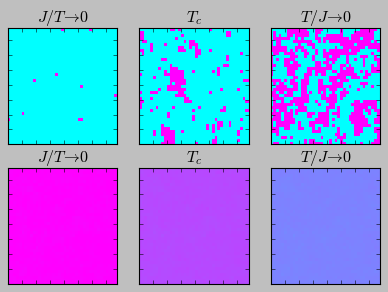

In [244]:
## draw restored Ising fields
plt.clf()
fig5, axes = plt.subplots(2,know_fea.shape[0], figsize=(2*know_fea.shape[0], 4))
for i,tdx in enumerate(know_fea):
    tem = tindex[i]
    # origin
    config_plot(axes[0,i], orig_isingc[i], 40, tem)
    prdc_isingf = np.reshape(prdc_Xnow[i],(40,40))
    # reconstruct
    config_plot(axes[1,i], prdc_isingf, 40, tem)
    norm_isingf = np.copy(prdc_isingf)
fig5.savefig('PCA reverse Ising.png')

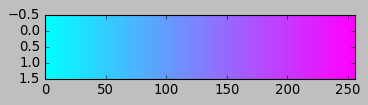

In [53]:
## colormap
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.clf()
plt.figure(figsize=(5,1))
plt.imshow(gradient, aspect='auto', cmap=plt.get_cmap('cool'))